In [1]:
# making training data from annotations

In [4]:
## Import libraries

# general
import os
import gc
import glob
import math
import numpy as np
import itertools
import slidingwindow as sw

# rasters
import rasterio
from rasterio.mask import mask

# shapes
import fiona
import shapefile
import shapely
from shapely.geometry import shape, Polygon, box, MultiPolygon
from shapely.ops import cascaded_union, unary_union

# for transormations
import pyproj
from shapely.ops import transform
from functools import partial

# working with images
from PIL import Image
from skimage import exposure
from skimage.io import imsave, imread

# visualizations
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [5]:
# load helper functions

def wgs2epsgzone(x,y):
    EPSG = 32700-round((45+y)/90,0)*100+round((183+x)/6,0)
    UTM_EPSG_code = EPSG
    
    return int(UTM_EPSG_code)

def check_valid_geometries(shapefile_path):
    
    shape_list = []

    for pol in fiona.open(shapefile_path):
        if pol['geometry'] != None:
                shape_list.append(pol)
            
    return shape_list

In [29]:
# set parameters
plot_results = False

chunk_size_pix = 400
overlap_frac = 0.2
label = 'tree'

# set bands https://sites.google.com/a/daffodilsw.com/green-city-watch/project-guidelines/data
# [r g b]
band_list = [6,4,2] 

# define paths with training data polygons
annotations_file_path = '../../data/data_merged/annotations/*.shp'

# define paths with raster data
rasters_file_path = '../../data/data_merged/tif/*.tif'

# define paths with contrast polygon (area with trees)
contrast_file_path = '../../data/data_merged/contrast/*.shp'

# output folder
output_path = '../../data/data_merged/training_data/test_2/'

In [15]:
# find all files in folders for specific classes
# find current working directory 
cwd = os.getcwd()

# find files in shapefile folder
annotations_shape_files = glob.glob(annotations_file_path)

# find files in raster folder
raster_files = glob.glob(rasters_file_path)
raster_files, annotations_shape_files
# load raster data
dataset = rasterio.open(raster_files[0])

# load annotations
annotations_valid_shape_list = check_valid_geometries(annotations_shape_files[0])
# convert list to shapely MultiPolgyons
annotations_MultiPoly = MultiPolygon([shape(pol['geometry']) for pol in fiona.open(annotations_shape_files[0])])

number of annotations:  4946


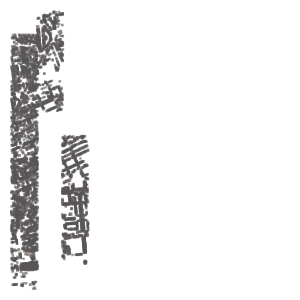

In [16]:
# inspect annotations
print('number of annotations: ', len(annotations_MultiPoly))
annotations_MultiPoly

In [17]:
# crop raster file to annotation extend
x_min_annotations, y_min_annotations, x_max_annotations, y_max_annotations = annotations_MultiPoly.bounds
chunk_bbox_org = box(x_min_annotations, y_min_annotations, x_max_annotations, y_max_annotations)
# crop
out_img, out_transform = mask(dataset, shapes=[chunk_bbox_org], crop=True)

In [18]:
## get raster bbox
# convert bounds to polygon
x_min_data, y_min_data, x_max_data, y_max_data = dataset.bounds
poly_raster_bounds = Polygon([(x_min_data, y_min_data), 
                              (x_min_data, y_max_data), 
                              (x_max_data, y_max_data), 
                              (x_max_data, y_min_data)])


# get raster metadata

x_pix_size_m = dataset.meta['transform'][0]
y_pix_size_m = dataset.meta['transform'][4]

x_raster_size_pix = dataset.meta['width']
y_raster_size_pix = dataset.meta['height']

In [19]:
# check overlap between annotations and raster
annotations_MultiPoly_union = unary_union(annotations_MultiPoly)
    
total_n = len(annotations_MultiPoly_union)
overlap_n = len(poly_raster_bounds.intersection(annotations_MultiPoly_union))

# check if overlap is complete
if  overlap_n == total_n:
    print('datasets overlap entirely')
else:
    print('Datasets do not completely overlap')
    print('Overlap is:' ,round(overlap_n/total_n,3)*100, '% ', overlap_n, '/', total_n)

datasets overlap entirely


In [20]:
# Generate the set of windows
windows = sw.generate(np.rot90(np.fliplr(dataset.read().T)), sw.DimOrder.HeightWidthChannel, chunk_size_pix, overlap_frac)

In [37]:
## calculate band min max for specific bands base on selected area
# find files in shapefile folder
contrast_shape_files = glob.glob(contrast_file_path)
contrast_valid_shape_list = check_valid_geometries(contrast_shape_files[0])

# convert list to shapely MultiPolgyons
contrast_shape = shape(contrast_valid_shape_list[0]['geometry'])

out_img_chunk, out_transform_chunk = mask(dataset, shapes=[contrast_shape], crop=True)

img_plot_raw = out_img_chunk[band_list,:,:]
img_plot = np.rot90(np.fliplr(img_plot_raw.T))

band_minmax = []

for band in range(3):
    p_1, p_2 = np.percentile(img_plot[:,:,band], (2, 98))

    band_minmax.append([p_1, p_2])
    
band_minmax

[[1371.0, 4620.0], [644.0, 1500.7799999999988], [904.0, 1566.0]]

In [39]:
# loop over chunks 
for i in tqdm(range(len(windows))):

        # convert chunk coordinates to bbox
        x_min = (windows[i].x * x_pix_size_m) + x_min_data
        x_max = ((windows[i].x + windows[i].w) * x_pix_size_m) + x_min_data
        y_min = (windows[i].y * abs(y_pix_size_m)) + y_min_data
        y_max = ((windows[i].y + windows[i].h) * abs(y_pix_size_m)) + y_min_data
    
        # read dataset
        dataset = rasterio.open(raster_files[0])
        x_min_data, y_min_data, x_max_data, y_max_data = dataset.bounds
        
        # clip raster file
        poly_chunk_bounds = Polygon([(x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min)]) 
        out_img_chunk, out_transform_chunk = mask(dataset, shapes=[poly_chunk_bounds], crop=True)
                      
        # loop over tree bboxes
        x_min_chunk = out_transform_chunk[2]
        y_min_chunk = out_transform_chunk[5]
      
        # select only bboxes that are fully within the chunk
        chunk_MultiPoly = MultiPolygon([poly_chunk_bounds.intersection(poly) for poly in annotations_MultiPoly if poly.within(poly_chunk_bounds)])
        
        # only continue if there are boxes
        if len(chunk_MultiPoly) == 0:
            print('no annotations in chunk', i)
            continue
        
        # get band data from raster and transform
        img_plot_raw = out_img_chunk[band_list,:,:]
        img_plot = np.rot90(np.fliplr(img_plot_raw.T))
        img_plot_enhance = np.array(img_plot, copy=True)
    
        ##### tif file #####
        # generate tiff profile 
        profile = dataset.profile
        profile['transform'] = out_transform_chunk
        profile['width'] = windows[i].w
        profile['height'] = windows[i].h
        
        # write tif file
        file_path_tif = '{0}example_{1:03d}.tif'.format(output_path,i)
        file_name_tif = 'example_{0:03d}.tif'.format(i)
        with rasterio.open(file_path_tif, 'w', **profile) as dst:
            dst.write(out_img_chunk)
        
        ##### jpg file #####
        # apply band specific contrast optimization
        for band in range(3):            
            p_1, p_2 = band_minmax[band]
            img_plot_enhance[:,:,band] = exposure.rescale_intensity(img_plot[:,:,band], 
                                                            in_range=(p_1, p_2), 
                                                            out_range = 'uint8')

        # write jpg file
        file_path_jpg = '{0}example_{1:03d}.jpg'.format(output_path,i)
        file_name_jpg = 'example_{0:03d}.jpg'.format(i)
        imsave(file_path_jpg, img_plot_enhance.astype('uint8'))
                        
        ##### annotations files #####
        # get annotation coordinates
        x = abs(np.array([poly.exterior.coords.xy[0] for poly in chunk_MultiPoly]) - x_min_chunk) * 1/out_transform_chunk[0]
        y = abs(np.array([poly.exterior.coords.xy[1] for poly in chunk_MultiPoly]) - y_min_chunk) * 1/out_transform_chunk[0]

        # write annotations to annotation file
        for i in range(len(x)):
            x_min_bbox = np.round(x[i]).astype(int).min()
            x_max_bbox = np.round(x[i]).astype(int).max()
            y_min_bbox = np.round(y[i]).astype(int).min()
            y_max_bbox = np.round(y[i]).astype(int).max()
            
            string_list_tif = [file_name_tif, str(x_min_bbox), str(y_min_bbox), str(x_max_bbox), str(y_max_bbox), label]
            string_tif = ",".join(string_list_tif)
            
            with open('{0}annotations_tif.txt'.format(output_path,i), 'a') as file:
                file.write(string_tif + "\n")
                
            y_min_box_reverse = chunk_size_pix - y_min_bbox
            y_max_box_reverse = chunk_size_pix - y_max_bbox            
            
            string_list_jpg = [file_name_jpg, str(x_min_bbox), str(y_min_box_reverse), str(x_max_bbox), str(y_max_box_reverse), label]
            string_jpg = ",".join(string_list_jpg)
            
            with open('{0}annotations_jpg.txt'.format(output_path,i), 'a') as file:
                file.write(string_jpg + "\n")
           
        
        ##### plotting #####        
        if plot_results:
            
            for band in range(3):
                plt.subplot(211, label = 'bands')
                plt.hist(img_plot[:,:,band].flatten(),100)
                plt.subplot(212, label = 'bands')
                plt.hist(img_plot_enhance[:,:,band].flatten(),100)
                axes = plt.gca()
                axes.set_ylim([0,1e4])
                
            plt.show()
            
            plt.figure(figsize = (20,20))
            plt.subplot(121)
            plt.title(['rescaled intesity min value: ', p_1, ' max value: ', p_2])
            plt.imshow(img_plot_enhance.astype('uint8')) 

            for i in range(len(x)):
                plt.plot(x[i],y[i], color = 'red')
                
            plt.show()     
        
        # clear memory
        gc.collect()
        

no annotations in chunk 35
no annotations in chunk 36
no annotations in chunk 37
no annotations in chunk 73
no annotations in chunk 74
no annotations in chunk 75
no annotations in chunk 77
no annotations in chunk 111
no annotations in chunk 112
no annotations in chunk 113
no annotations in chunk 115
no annotations in chunk 151
no annotations in chunk 152
no annotations in chunk 153
no annotations in chunk 154
no annotations in chunk 155
no annotations in chunk 156
no annotations in chunk 157
no annotations in chunk 158
no annotations in chunk 159
no annotations in chunk 160
no annotations in chunk 161
no annotations in chunk 162
no annotations in chunk 163
no annotations in chunk 164
no annotations in chunk 165
no annotations in chunk 166
no annotations in chunk 167
no annotations in chunk 168
no annotations in chunk 169
no annotations in chunk 170
no annotations in chunk 171
no annotations in chunk 172
no annotations in chunk 173
no annotations in chunk 174
no annotations in chunk 190

In [31]:
y_min_box_reverse

39

In [34]:
y_min_bbox

361